In [2]:
import pandas as pd
import numpy as np
import os.path as op
import unicodedata
import sys
from gensim.models import FastText
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict, StratifiedShuffleSplit, train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier


basename = "/Users/Adrian/Desktop/WDDS/Tweet-Classification-Diabetes-Distress/"
path_utils = op.join(basename , "utils")
sys.path.insert(0, path_utils)

from sys_utils import load_library
from tweet_utils import *

from preprocess import Preprocess
prep = Preprocess()

model_we = FastText.load("/Users/Adrian/Desktop/WDDS/Models_Data/FastText_model/ft_wordembeddings_09112018.model")
#model_we = FastText.load("/Users/Adrian/Desktop/WDDS/Models_Data/FastText_model/ft_wordembeddings_dim300_minCount3_iter50_26032019")

trainingData = pd.read_csv("ManualLabels_sampleJokes.csv")#, usecols=["text", "user_description", "user_name", "user_screen_name", "HasDiabetes", 
#                            "Type_Diabetes", "Sexe", "History_HasDiab", "History_TypeDiab", "History_Sex"],
                           #converters={'user_description': lambda x: tt(x)}
                           #converters={'HasDiabetes': lambda x: int(x, 16)}
                          #dtype={'Type_Diabetes':np.int32}
 #                         )


print(trainingData.dtypes)
trainingData.head(5)

[nltk_data] Downloading package punkt to /Users/Adrian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Adrian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
id                  float64
text                 object
user_description     object
user_name            object
user_screen_name     object
isJoke                int64
get_diabetes        float64
dtype: object


,id,text,user_description,user_name,user_screen_name,isJoke,get_diabetes
0,9.981736e+17,"@brostvles No, they don't. But if you wanna ge...","I write about broken people, outcasts, unusual...",J.S. Mueller,JSMueller_5150,0,NaN
1,9.755911e+17,@dougiec0n still shocked their reengagement di...,.,Sam,sgeezy99,1,NaN
2,1.083126e+18,❤️❤️diabetes here I come! https://t.co/afD4gjfQK5,NaN,sarah stewart,StewCrew3,1,NaN
3,1.089760e+18,@DenisJSM I don’t want diabetes but I do want ...,“Intelligence is proved not by ease of learnin...,Jennifer Lopez,Jennifer_guppy,1,NaN
4,9.360871e+17,i need a glucose guardian in my life https://t...,probs being rly gay somewhere. 👻 snap: tterbre...,brett,TT3RB,0,NaN


In [15]:
model_we.vector_size

200

In [3]:
def preprocess_tweet(tweet):
    tweet = prep.replace_hashtags_URL_USER(tweet, mode_URL="replace", mode_Mentions="replace")
    tweet = prep.tokenize(tweet)
    return tweet

def userName_to_vec(name):
    #print("name:", name)
    try:
        firstName = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8', 'ignore').split(" ")[0].replace(" ", "")
        vec = model_we[firstName]
    except:
        vec = np.zeros((200, ))

    return vec

    
label = "isJoke"
data_pd = trainingData[["text", "user_description", "user_name", label]]
data_pd.head()

data_pd.text = data_pd.text.map(lambda tweet: tweet_vectorizer(preprocess_tweet(tweet), model_we))
data_pd.user_description = data_pd.user_description.map(lambda userDesc: np.zeros((200, )) 
                                                if isinstance(userDesc, float) or userDesc == " " 
                                                else tweet_vectorizer(preprocess_tweet(userDesc), model_we))    
data_pd.user_name = data_pd.user_name.map(userName_to_vec)

# remove the tweets that are empty because there is no word embedding
data_pd = data_pd[data_pd["text"].apply(lambda x: len(x) > 0) ]
print(data_pd.shape)

data_pd.head(10)


/Users/Adrian/miniconda3/envs/deepscience/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embed

/Users/Adrian/miniconda3/envs/deepscience/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


(998, 4)


,text,user_description,user_name,isJoke
0,"[-0.049776763, -0.23180367, 0.046479348, 0.141...","[0.013143862, -0.10582442, 0.0333345, 0.094704...","[-0.055237867, -0.37541336, -0.2949726, -0.101...",0
1,"[0.057523582, -0.30855343, -0.11400492, 0.2300...","[-0.08786992, -0.009789169, 0.12711863, 0.2365...","[-0.22964455, -0.26537615, -0.4669214, -0.2913...",1
2,"[-0.12516218, -0.23781171, -0.015573966, 0.175...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.040215, 0.44242898, -0.9820353, 0.36652038,...",1
3,"[-0.072586514, -0.2300713, 0.0039286576, 0.125...","[0.22339085, -0.13608888, 0.023511782, 0.22591...","[-0.24501695, -0.24318415, -0.33899713, -0.621...",1
4,"[0.037482217, -0.19833796, -0.17055039, 0.1087...","[-0.03617359, -0.12584208, -0.076571055, 0.082...","[0.31188297, -0.17345856, -0.16029365, -0.2219...",0
5,"[0.06471156, -0.36883724, -0.030615838, 0.2193...","[-0.09710225, -0.18520164, -0.07955421, 0.0714...","[0.29170498, -0.37897596, 0.41631743, -0.11619...",0
6,"[0.11817316, -0.29072195, -0.04093187, 0.07789...","[-0.06744213, -0.20963554, -0.010382278, 0.126...","[0.10386381, -0.3271309, -0.31992787, -0.04593...",0
7,"[0.19957821, -0.36899775, 0.39326176, -0.13987...","[-0.055475757, -0.15953872, -0.01571358, -0.00...","[-0.351335, 0.034861516, 0.27016765, 0.1566087...",0
8,"[0.05157101, -0.39877817, -0.07805453, 0.09229...","[-0.031474244, -0.1387948, -0.0953588, 0.12239...","[-0.055502202, -0.5707155, -0.38313675, -0.513...",1
9,"[0.14433488, -0.29532123, -0.026986029, 0.2561...","[0.049687047, -0.13538592, -0.048792303, 0.029...","[-0.22566022, -0.19002877, 0.08349293, 0.10990...",1


In [4]:
class ItemSelect(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        #print("data: ", data.shape, type(data))
        #print("data[key]: ", data[self.key].shape, type(data[self.key]))
        #print("data[key].values: ", data[self.key].values.shape, type(data[self.key].values))
        #print("data[key].values.tolist: ", len(data[self.key].values.tolist()), type(data[self.key].values.tolist()))
        #print("asarray(data[key].values.tolist): ", np.asarray(data[self.key].values.tolist()).shape, type(np.asarray(data[self.key].values.tolist())))
        #print("data[key].head(): ", data[self.key].head())
        return np.asarray(data[self.key].values.tolist())
"""
class SMOTE_sampling(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        #print("data: ", data.shape, type(data))
        #print("data[key]: ", data[self.key].shape, type(data[self.key]))
        #print("data[key].values: ", data[self.key].values.shape, type(data[self.key].values))
        #print("data[key].values.tolist: ", len(data[self.key].values.tolist()), type(data[self.key].values.tolist()))
        #print("asarray(data[key].values.tolist): ", np.asarray(data[self.key].values.tolist()).shape, type(np.asarray(data[self.key].values.tolist())))
        #print("data[key].head(): ", data[self.key].head())
        return np.asarray(data[self.key].values.tolist())
"""
    
# choose algo:
#---------------------------------------------------------------------------
modelAlgo = "SVC"

if modelAlgo == "MultinomialNB":
    model = MultinomialNB(random_state=0)
elif modelAlgo == "SVC":
    model = SVC(random_state=0)
elif modelAlgo == "logReg":
    model = LogisticRegression(random_state=0)
elif modelAlgo == "RandomForest" :
    model = RandomForestClassifier(random_state=0)
elif modelAlgo == "XGBoost" :
    model = XGBClassifier(random_state=0)
elif modelAlgo == "MLP" :
    model = MLPClassifier(early_stopping=True, batch_size=32, random_state=0)
#model = KerasClassifier(build_fn=create_model, epochs=10)





from imblearn.pipeline import Pipeline
pipeline  = Pipeline([
                #("debuge", Debug("start")),
                ('union', FeatureUnion(
                            transformer_list = [
                                ('tweet', Pipeline([
                                    ('tweetsSelector', ItemSelect(key='text')),
                                    #("debugeq", Debug("text Selector")),
                                ])),  
                                ('userDesc', Pipeline([
                                    ('userDescSelector', ItemSelect(key='user_description'))
                                ])),
#                                ('userName', Pipeline([
#                                    ('userNameSelector', ItemSelect(key='user_name'))
#                                ]))
                                
                            ],
                )),
                #("debuggg", Debug("before model")),
                ('smote', SMOTE(random_state=12, ratio = 1.0, n_jobs=-1)),
                ('model', model),
                #("debuggg", Debug("after model")),
            ])


# parameter grid for grid search by using fastText embeddings
parameters = {
                'union__transformer_weights' : [{"tweet": 1, "userDesc":0},
                                                {"tweet": 1, "userDesc":0.2}, 
#                                                {"tweet": 1, "userDesc":0.3},
#                                                {"tweet": 1, "userDesc":0.1},
#                                                {"tweet": 1, "userDesc":1},
#                                                {"tweet": 1, "userDesc":0.8, "userName":0.4},
#                                                {"tweet": 1, "userDesc":0.8, "userName":0.5},
#                                                {"tweet": 1, "userDesc":0.8, "userName":0.6},
#                                                {"tweet": 1, "userDesc":0.7, "userName":0.5},
#                                                {"tweet": 1, "userDesc":0.9, "userName":0.5},
                                                ],
                'smote__k_neighbors' : [3, 5],

#               # param for SVC
               'model__kernel' : ["linear"],#["linear", "poly", "rbf"],
               'model__C' : [1.0, 0.5, 0.1],
               'model__tol' : [1e-1, 1e-2],
#               'model__class_weight' : ["balanced", {1:1.0}, {1:1.2}],
#
#               # param for RandomForestClassifier
#               'model__n_estimators' : [50, 100, 150],
#               'model__criterion' : ['gini', 'entropy'],
#               'model__max_features' : ['auto', 'log2'],
#               'model__max_depth' : [ 5, 10, 20, 30]

#               'model__max_depth' : [3],#[3,4],
#               'model__learning_rate' : [0.001, 0.01, 0.1],
#               'model__booster' : ["gblinear"], #["gbtree", "gblinear", "dart"],
#               'model__gamma' : [0, 0.01],
#               'model__n_estimators' : [80, 100, 150, 200],
#               'model__reg_alpha' : [0, 0.1],
#               'model__reg_lambda' : [0.5, 1.0, 1.5]
    
                 # param for Multi layer perceptron
#                 'model__hidden_layer_sizes' : [(32), (16), (32, 16)],
#                 'model__activation' : ['relu', 'tanh', 'logistic'],
#                 'model__solver' : ['adam', 'sgd', 'lbfgs'],
#                'model__learning_rate' : ['constant', 'invscaling'],
#                 'model__tol' : [ 1e-3, 1e-4],
                 #'model__alpha' : [ 1e-3, 1e-4, 1e-5],
#                  'model__max_iter' : [200, 300],
#                  'model__beta_1' : [0.990, 0.999],
#                  'model__beta_2' : [1e-7, 1e-8, 1e-9]
    
}


In [5]:
X = data_pd[["text", "user_description"]]
y = data_pd[label]
print("X :", X.shape, type(X))
print("y.unique: ", y.unique())
print(y.value_counts())
print(y.isnull().values.any())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 


#X_train_pd = pd.DataFrame(X_train_res, columns=["text", "user_description"])
#X_test_pd = pd.DataFrame(X_test, columns=["text", "user_description"])
X_train_pd = pd.DataFrame(X_train, columns=["text", "user_description"])
X_test_pd = pd.DataFrame(X_test, columns=["text", "user_description"])

    
print("Start Grid search...")
grid = GridSearchCV(pipeline, parameters, cv=10, n_jobs=-1, verbose=2, scoring="recall")#, scoring="roc_auc") # recall, f1, roc_auc
grid.fit(X_train_pd, y_train)
print("\nBest: %f using %s" % (grid.best_score_, grid.best_params_))

y_pred = grid.best_estimator_.predict(X_test_pd)
print("F1-Score:", f1_score(y_test, y_pred))
print("Precision: ",precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))    
print("Accuracy: ", accuracy_score(y_test, y_pred)) 
print("roc auc: ", roc_auc_score(y_test, y_pred))   
print("Performance overall: ")
print(classification_report(y_test, y_pred))



X : (998, 2) <class 'pandas.core.frame.DataFrame'>
y.unique:  [0 1]
0    748
1    250
Name: isJoke, dtype: int64
False
Start Grid search...
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   40.3s finished
/Users/Adrian/miniconda3/envs/deepscience/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



Best: 0.703712 using {'model__C': 0.5, 'model__kernel': 'linear', 'model__tol': 0.1, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.2}}
F1-Score: 0.6810810810810811
Precision:  0.6057692307692307
Recall:  0.7777777777777778
Accuracy:  0.8033333333333333
roc auc:  0.7952815829528159
Performance overall: 
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       219
           1       0.61      0.78      0.68        81

   micro avg       0.80      0.80      0.80       300
   macro avg       0.76      0.80      0.77       300
weighted avg       0.83      0.80      0.81       300



In [11]:
X_test_pd.head()



,text,user_description
270,"[0.069522016, -0.30805513, -0.13959946, 0.1407...","[-0.17955735, -0.26246247, -0.025229683, 0.046..."
725,"[0.17349738, -0.45734555, 0.037743352, -0.0316...","[0.06528581, -0.4007286, 0.029112494, 0.035182..."
31,"[0.038428854, -0.25698596, -0.051925257, 0.090...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
342,"[0.13098559, -0.25688875, 0.024756799, 0.05859...","[-0.09976374, -0.8109173, -0.025298746, 0.2312..."
604,"[0.079197325, -0.2610952, -0.02114224, 0.10356...","[-0.06663675, -0.07773214, -0.15233414, 0.2320..."


In [ ]:
# SVC - Smote - 300 - Score default
#Best: 0.815186 using {'model__C': 0.1, 'model__class_weight': {1: 0.5}, 'model__kernel': 'linear', 'model__tol': 0.1, 'smote__k_neighbors': 3, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0}}
#F1-Score: 0.5499999999999999
#Precision:  0.8461538461538461
#Recall:  0.4074074074074074
#Accuracy:  0.82
#roc auc:  0.6900050735667174
#Performance overall: 
#              precision    recall  f1-score   support

#   (noJoke)0       0.82      0.97      0.89       219
#    (joke) 1       0.85      0.41      0.55        81

#   micro avg       0.82      0.82      0.82       300
#   macro avg       0.83      0.69      0.72       300
#weighted avg       0.82      0.82      0.80       300

# SVC - Smote oversampling - 200 dim vector - Score default (acc)
#Best: 0.805158 using {'model__C': 0.01, 'model__class_weight': 'balanced', 'model__kernel': 'linear', 'model__tol': 0.1, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0}}
#F1-Score: 0.6962025316455697
#Precision:  0.7142857142857143
#Recall:  0.6790123456790124
#Accuracy:  0.84
#roc auc:  0.7892778623372231
#Performance overall: 
#              precision    recall  f1-score   support

#   (noJoke)0       0.88      0.90      0.89       219
#    (joke) 1       0.71      0.68      0.70        81

#   micro avg       0.84      0.84      0.84       300
#   macro avg       0.80      0.79      0.79       300
#weighted avg       0.84      0.84      0.84       300

# SVC - Smote - 300 - Score recall
#Best: 0.815987 using {'model__C': 0.01, 'model__class_weight': 'balanced', 'model__kernel': 'linear', 'model__tol': 0.1, 'smote__k_neighbors': 8, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0}}
#F1-Score: 0.6231155778894473
#Precision:  0.5254237288135594
#Recall:  0.7654320987654321
#Accuracy:  0.75
#roc auc:  0.7548621681041772
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.90      0.74      0.81       219
#           1       0.53      0.77      0.62        81

#   micro avg       0.75      0.75      0.75       300
#   macro avg       0.71      0.75      0.72       300
#weighted avg       0.80      0.75      0.76       300


# SVC - Smote oversampling - 200 dim vector - Score recall
#Best: 0.703712 using {'model__C': 0.5, 'model__kernel': 'linear', 'model__tol': 0.1, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.2}}
#F1-Score: 0.6810810810810811
#Precision:  0.6057692307692307
#Recall:  0.7777777777777778
#Accuracy:  0.8033333333333333
#roc auc:  0.7952815829528159
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.91      0.81      0.86       219  (nojoke)
#           1       0.61      0.78      0.68        81  (joke)

#   micro avg       0.80      0.80      0.80       300
#   macro avg       0.76      0.80      0.77       300
#weighted avg       0.83      0.80      0.81       300


# XGBoost - SMOTE - 300 dim - score default
#Best: 0.767908 using {'model__booster': 'gblinear', 'model__learning_rate': 0.001, 'model__max_depth': 3, 'model__n_estimators': 80, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0}}
#F1-Score: 0.6493506493506493
#Precision:  0.684931506849315
#Recall:  0.6172839506172839
#Accuracy:  0.82
#roc auc:  0.7561305597835278
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.86      0.89      0.88       219
#           1       0.68      0.62      0.65        81

#   micro avg       0.82      0.82      0.82       300
#   macro avg       0.77      0.76      0.76       300
#weighted avg       0.82      0.82      0.82       300

# XGBoost - Smote - 300 score recall
#Best: 0.686015 using {'model__booster': 'gblinear', 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 80, 'smote__k_neighbors': 8, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.2}}
#F1-Score: 0.6276595744680851
#Precision:  0.5514018691588785
#Recall:  0.7283950617283951
#Accuracy:  0.7666666666666667
#roc auc:  0.7546084897683072
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.89      0.78      0.83       219
#           1       0.55      0.73      0.63        81

#   micro avg       0.77      0.77      0.77       300
#   macro avg       0.72      0.75      0.73       300
#weighted avg       0.80      0.77      0.78       300


# XGBoost - Smote - 200 score recall
# Best: 0.685635 using {'model__booster': 'gblinear', 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 150, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.2}}
#F1-Score: 0.6740331491712707
#Precision:  0.61
#Recall:  0.7530864197530864
#Accuracy:  0.8033333333333333
#roc auc:  0.7875021139861322
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.90      0.82      0.86       219
#           1       0.61      0.75      0.67        81

#   micro avg       0.80      0.80      0.80       300
#   macro avg       0.76      0.79      0.77       300
#weighted avg       0.82      0.80      0.81       300

# SVC - Smote oversampling - 200 dim vector - Score recall
#Best: 0.703712 using {'model__C': 0.5, 'model__kernel': 'linear', 'model__tol': 0.1, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.2}}
#F1-Score: 0.6810810810810811
#Precision:  0.6057692307692307
#Recall:  0.7777777777777778
#Accuracy:  0.8033333333333333
#roc auc:  0.7952815829528159
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.91      0.81      0.86       219  (nojoke)
#           1       0.61      0.78      0.68        81  (joke)

#   micro avg       0.80      0.80      0.80       300
#   macro avg       0.76      0.80      0.77       300
#weighted avg       0.83      0.80      0.81       300



Classes before: ['0' '1']
unique labels: [0 1]
Classes: ['0' '1']
Confusion matrix, without normalization
[[178  41]
 [ 18  63]]
Classes before: ['0' '1']
unique labels: [0 1]
Classes: ['0' '1']
Normalized confusion matrix
[[0.81 0.19]
 [0.22 0.78]]


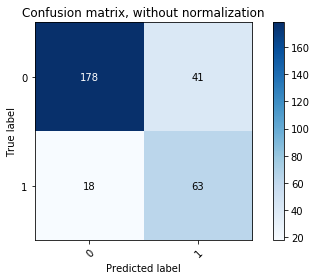

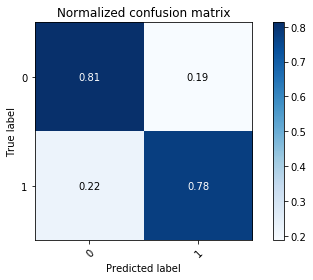

In [54]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    print("Classes before:", classes)
    print("unique labels:", unique_labels(y_true, y_pred))
    classes = classes[unique_labels(y_true, y_pred)]
    print("Classes:", classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



np.set_printoptions(precision=2)

#class_names = np.array(["M", "F", "U"])
class_names = np.array(["0", "1"])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [63]:
# SVC - Smote oversampling - 200 dim vector - Score recall
#Best: 0.703712 using {'model__C': 0.5, 'model__kernel': 'linear', 'model__tol': 0.1, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.2}}
#F1-Score: 0.6810810810810811
#Precision:  0.6057692307692307
#Recall:  0.7777777777777778
#Accuracy:  0.8033333333333333
#roc auc:  0.7952815829528159
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.91      0.81      0.86       219  (nojoke)
#           1       0.61      0.78      0.68        81  (joke)

#   micro avg       0.80      0.80      0.80       300
#   macro avg       0.76      0.80      0.77       300
#weighted avg       0.83      0.80      0.81       300

from sklearn.externals import joblib
from imblearn.pipeline import Pipeline


pipeline  = Pipeline([
                ('union', FeatureUnion(
                            transformer_list = [
                                ('tweet', Pipeline([ ('tweetsSelector', ItemSelect(key='text')) ])),  
                                ('userDesc', Pipeline([ ('userDescSelector', ItemSelect(key='user_description')) ])),  
                            ],
                )),
                ('smote', SMOTE(random_state=12, ratio = 1.0, n_jobs=-1)),
                ('model', model),
            ])


# parameter grid for grid search by using fastText embeddings
parameters = {
               'union__transformer_weights' : [{"tweet": 1, "userDesc":0.2}],
               'smote__k_neighbors' : [5],
               'model__kernel' : ["linear"],
               'model__C' : [0.5],
               'model__tol' : [1e-1],
}
"""

# create best pipeline
best_pipeline = pipeline
best_pipeline.set_params(**parameters)

print("Train model...")
best_pipeline_trained = best_pipeline.fit(X_train_pd, y_train)

# save best model
print("Save model to {} ...".format("jokesClassifier_05042019.model"))
joblib.dump(best_pipeline_trained, "jokesClassifier_05042019.model")
"""

joblib.dump(grid.best_estimator_, "jokesClassifier_05042019.model")


print(grid.best_estimator_)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('tweet', Pipeline(memory=None, steps=[('tweetsSelector', ItemSelect(key='text'))])), ('userDesc', Pipeline(memory=None,
     steps=[('userDescSelector', ItemSelect(key='user_description'))]))],
       transformer_weights={'tweet': ...linear', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.1, verbose=False))])


In [13]:
from sklearn.externals import joblib

estim = joblib.load("jokesClassifier_05042019.model")
print(estim)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('tweet', Pipeline(memory=None, steps=[('tweetsSelector', ItemSelect(key='text'))])), ('userDesc', Pipeline(memory=None,
     steps=[('userDescSelector', ItemSelect(key='user_description'))]))],
       transformer_weights={'tweet': ...linear', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.1, verbose=False))])


In [14]:
estim.predict(X_test_pd)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0])